In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
import scipy.signal as ss
import xgboost as xgb

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [164]:
holidays_events = pd.read_csv("https://www.dropbox.com/s/bxyamlpevkiwwoq/holidays_events.csv?dl=1")
holidays_events["holiday_type"] = holidays_events["type"]
holidays_events.drop(["type"],axis=1,inplace=True)
oil = pd.read_csv("https://www.dropbox.com/s/l6ln0ztl4m0pw3a/oil.csv?dl=1",parse_dates=['date'],index_col='date')
oil2 = pd.read_csv("https://www.dropbox.com/s/l6ln0ztl4m0pw3a/oil.csv?dl=1")
sample_submission = pd.read_csv("https://www.dropbox.com/s/68jjl61x6u3klos/sample_submission.csv?dl=1")
stores = pd.read_csv("https://www.dropbox.com/s/lcxn6r9bs2exguq/stores.csv?dl=1")
test = pd.read_csv("https://www.dropbox.com/s/cvdo1gn7r5lu2uz/test.csv?dl=1",index_col='id')
train = pd.read_csv("https://www.dropbox.com/s/s8p2b5awnuqfk0d/train.csv?dl=1",index_col='id')
transactions = pd.read_csv("https://www.dropbox.com/s/92fij9bcwt0e0cj/transactions.csv?dl=1")

C:\Users\ndzad\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [180]:
def przygotowanie_danych_rodzinnych(df, family):
    #Łaczymy z pozostałymi zbiorami
    df = df.merge(stores,how="left",left_on=['store_nbr'],right_on=['store_nbr'])
    df = df.merge(transactions,how="left",left_on=['date','store_nbr'],right_on=['date','store_nbr'])
    df = df.merge(holidays_events,how="left",left_on=['date'],right_on=['date'])
    #Wybieramy family ze zbioru traningowego
    df_fam = df.loc[(df['family']==family)]
    #Średnia po sales
    #df_fam.groupby(['date'])['sales'].mean().to_frame()

    df_fam['dayofweek'] = pd.DatetimeIndex(df_fam['date']).dayofweek + 1
    df_fam['month'] = pd.to_datetime(df_fam['date']).dt.month
    #df_fam['year'] = pd.to_datetime(df_fam['date']).dt.year
    #One Hot Encoding
    final_df_fam = pd.get_dummies(df_fam,columns=["dayofweek","month","locale","store_nbr","city", "state", "type", "cluster","locale_name", "holiday_type"],prefix=["dayofweek","month","locale","store_nbr","city", "state", "type", "cluster","locale_name", "holiday_type"])
    
    # encoder = OneHotEncoder(handle_unknown='ignore')
    # #locale
    # encoder_df = pd.DataFrame(encoder.fit_transform(df_fam_merged[['locale']]).toarray())
    # final_df_fam = df_fam_merged.join(encoder_df)
    # final_df_fam.drop('locale', axis=1, inplace=True)
    # final_df_fam.rename(columns = {0:'isLocal',1:'isNational',2:'isRegional',3:'isNormalDay'}, inplace = True)
    # #day_of_week
    # encoder = OneHotEncoder(handle_unknown='ignore')
    # encoder_df = pd.DataFrame(encoder.fit_transform(df_fam_merged[['day_of_week']]).toarray())
    # final_df_fam = df_fam_merged.join(encoder_df)
    # final_df_fam.drop('day_of_week', axis=1, inplace=True)
    #final_df_fam.rename(columns = {0:'isLocal',1:'isNational',2:'isRegional',3:'isNormalDay'}, inplace = True)  

    #Dodanie oil
    df_fam_oil = final_df_fam.merge(oil2,how="left",left_on=['date'],right_on=['date'])
    #Interpolacja braków
    df_fam_oil.interpolate(method ='linear', limit_direction ='backward', inplace=True)
    df_fam_oil.drop(["description","transferred"],axis=1,inplace=True)
    return(df_fam_oil)

In [181]:
def przygotowanie_danych_sklepowych(df, store_nbr):
    #Łaczymy z pozostałymi zbiorami
    df = df.merge(stores,how="left",left_on=['store_nbr'],right_on=['store_nbr'])
    df = df.merge(transactions,how="left",left_on=['date','store_nbr'],right_on=['date','store_nbr'])
    df = df.merge(holidays_events,how="left",left_on=['date'],right_on=['date'])
    #Wybieramy store_nbr ze zbioru traningowego
    df_fam = df.loc[(df['store_nbr']==store_nbr)]
    #Średnia po sales
    #df_fam.groupby(['date'])['sales'].mean().to_frame()

    df_fam['dayofweek'] = pd.DatetimeIndex(df_fam['date']).dayofweek + 1
    df_fam['month'] = pd.to_datetime(df_fam['date']).dt.month
    #df_fam['year'] = pd.to_datetime(df_fam['date']).dt.year
    #One Hot Encoding
    final_df_fam = pd.get_dummies(df_fam,columns=["dayofweek","month","locale","family","city", "state", "type", "cluster","locale_name", "holiday_type"],prefix=["dayofweek","month","locale","family","city", "state", "type", "cluster","locale_name", "holiday_type"])
    
    # encoder = OneHotEncoder(handle_unknown='ignore')
    # #locale
    # encoder_df = pd.DataFrame(encoder.fit_transform(df_fam_merged[['locale']]).toarray())
    # final_df_fam = df_fam_merged.join(encoder_df)
    # final_df_fam.drop('locale', axis=1, inplace=True)
    # final_df_fam.rename(columns = {0:'isLocal',1:'isNational',2:'isRegional',3:'isNormalDay'}, inplace = True)
    # #day_of_week
    # encoder = OneHotEncoder(handle_unknown='ignore')
    # encoder_df = pd.DataFrame(encoder.fit_transform(df_fam_merged[['day_of_week']]).toarray())
    # final_df_fam = df_fam_merged.join(encoder_df)
    # final_df_fam.drop('day_of_week', axis=1, inplace=True)
    #final_df_fam.rename(columns = {0:'isLocal',1:'isNational',2:'isRegional',3:'isNormalDay'}, inplace = True)  

    #Dodanie oil
    df_fam_oil = final_df_fam.merge(oil2,how="left",left_on=['date'],right_on=['date'])
    #Interpolacja braków
    df_fam_oil.interpolate(method ='linear', limit_direction ='backward', inplace=True)
    df_fam_oil.drop(["description","transferred"],axis=1,inplace=True)
    return(df_fam_oil)

In [90]:
def podzial(df, date):
    train = df.loc[(df['date']<date)].drop(["date"],axis=1)
    test = df.loc[(df['date']>=date)].reset_index(drop=True).drop(["date"],axis=1)
    return(train,test)

In [143]:
def predykcja_sklep(df1,df2,type):
    df3 = df1.drop([type],axis=1).copy()
    df4 = df2.drop([type],axis=1).copy()
    X = df3.drop(['sales'],axis=1)
    Y = df3['sales']
    #print(X.head())
    #print(Y.head())
    df4_drop = df4.drop(['sales'],axis=1)
    model = xgb.XGBRFRegressor().fit(X,Y)
    Y_pred = model.predict(df4_drop)
    Y_df4 = df4['sales']
    print(mean_squared_error(Y_df4,Y_pred))
    return(model)

In [153]:
def predykcja_sklep_OLS(df1,df2,type):
    df3 = df1.drop([type],axis=1).copy()
    df4 = df2.drop([type],axis=1).copy()
    X = df3.drop(['sales'],axis=1)
    Y = df3['sales']
    #print(X.head())
    #print(Y.head())
    df4_drop = df4.drop(['sales'],axis=1)
    model = sm.OLS(Y,X).fit()
    Y_pred = model.predict(df4_drop)
    Y_df4 = df4['sales']
    print(mean_squared_error(Y_df4,Y_pred))

    return(model)

In [186]:
(train2,test2) = podzial(przygotowanie_danych_rodzinnych(train,'AUTOMOTIVE'),'2016-06-01')

C:\Users\ndzad\AppData\Local\Temp/ipykernel_19640/1555495844.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fam['dayofweek'] = pd.DatetimeIndex(df_fam['date']).dayofweek + 1
C:\Users\ndzad\AppData\Local\Temp/ipykernel_19640/1555495844.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fam['month'] = pd.to_datetime(df_fam['date']).dt.month


In [171]:
(train3,test3) = podzial(przygotowanie_danych_sklepowych(train,1),'2016-06-01')

C:\Users\ndzad\AppData\Local\Temp/ipykernel_19640/3469361090.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fam['dayofweek'] = pd.DatetimeIndex(df_fam['date']).dayofweek + 1
C:\Users\ndzad\AppData\Local\Temp/ipykernel_19640/3469361090.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fam['month'] = pd.to_datetime(df_fam['date']).dt.month
C:\Users\ndzad\AppData\Local\Temp/ipykernel_19640/3469361090.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [187]:
model_xgb = predykcja_sklep(train2,test2,'family')

22.706722578518193


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

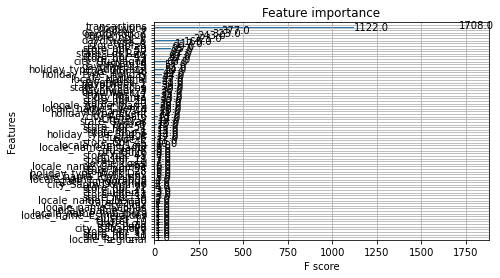

In [133]:
xgb.plot_importance(model_xgb)

In [173]:
model_ols = predykcja_sklep_OLS(train2,test2,'family')

23.952055095436368


In [174]:
test

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1
3029396,2017-08-31,9,PREPARED FOODS,0
3029397,2017-08-31,9,PRODUCE,1


In [182]:
test_t2 = przygotowanie_danych_rodzinnych(test,"AUTOMOTIVE")

C:\Users\ndzad\AppData\Local\Temp/ipykernel_19640/1555495844.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fam['dayofweek'] = pd.DatetimeIndex(df_fam['date']).dayofweek + 1
C:\Users\ndzad\AppData\Local\Temp/ipykernel_19640/1555495844.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fam['month'] = pd.to_datetime(df_fam['date']).dt.month


In [203]:
train2.drop(['date'],inplace=True)

KeyError: "['date'] not found in axis"

In [194]:
list(test_t2.columns), test2.columns

Index(['date', 'family', 'onpromotion', 'transactions', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6',
       ...
       'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15',
       'cluster_16', 'cluster_17', 'locale_name_Ambato',
       'holiday_type_Holiday', 'dcoilwtico'],
      dtype='object', length=130)

In [199]:
e = [v for v in list(test_t2.columns) if v not in list(train2.columns)]

In [200]:
e

['date']

In [188]:
model_xgb.predict()

ValueError: Feature shape mismatch, expected: 169, got 130